In [1]:
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from shapely.wkt import load as wktLoads
from shapely.wkt import dumps as wktDumps
from matplotlib import pyplot as plt

from tkinter import *
from tkinter import filedialog,messagebox
from PIL import Image,ImageTk

from SeqReader import seqFileHandler

In [2]:
def calcUninterupted(input):
    b = np.array(input)!=0
    b = b.astype(int)

    c = np.diff(b)
    
    
    starts = np.where(c<0)[0]
    ends = np.where(c>0)[0]

    if b[0]==0:
        starts = np.insert(starts,0,-1)
    if b[-1]==0:
        ends = np.append(ends,c.shape[0])

    counts = ends-starts
    
    return np.sum(counts),counts.shape[0]

In [3]:
def calcGaps(fileName=None, table=None, netPolygon=None, idealGap=0.02,debug=False,returnGapSets=False,
             drawGaps=False,drawHist=False,bgImage=None, title=None, gapsThreshold=200, restMinTime=3, restMaxDist=10):
    '''
    This function calculates gaps in tracks by finding time differences between two consecutive positions more than single frame time step. 
    It splits the whole image into across the net (darker areas) and outside the net (brighter areas) according to the net polygon passed as the parameter.
    
    The function uses tracking data in 12 columns table format. Each row is a position, which belongs to one of the tracks. The function expects, 
    that positions are sorted primarily by tracks and secondary by time (i.e. positions from one tracks going in one block with earlier positions 
    are before later ones). 1st and 2nd columns should be x and y (horizontal and vertical) coordinates of the given position respectively. Column 9 should contain 
    ID of the track (integer number). Finally last three colums (10th, 11th and 12th) represent the time stamp in seconds (POSIX time, calculated from 1 January 1970), 
    milliseconds and microseconds respectively. All other columns are not in use by this function, but has to be present.
    Input:
        - `fileName`: name of the tab delimited text file, which contains table with track data. Either `fileName` or `table` should not be `None`, otherwise, the 
        function will raise a ValueError. 
        - `table`: 2D array containing track data. Either `fileName` or `table` should not be `None`, otherwise, the 
        function will raise a ValueError. 
        - `netPolygon`: shapely.geometry.polygon.Polygon instance, which is used for splitting the region into net and no net areas.
        - `idealGap`: Single frame time step, time difference between two consecutive frames, in seconds. Default: 0.02 seconds
        - `debug`: Boolean, if set to `True`, will print debuging/progress messages. Default: `False`.
        - `returnGapSets`: Boolean, if set to `True` it will return raw sets of gaps (sizes of each gap). Will add extra three arrays for all gaps, for gaps outside net and gaps 
        across the net. Default: `False`.
        - `drawGaps`: Boolean, if set to `True`, will plot all gaps on the background provided. Default: `False`
        - `drawHist`: Boolean, if set to `True`, will plot three histograms (bar charts) with distributions of the gap sizes for the whole recording, for across net area and 
        for outside net area. Defauls: `False`.
        - `bgImage`: Numpy array, image of the background. If `None`, will raise a value error.
        - `title`: Addition to the plot titles to describe what is being tested. Default: `None`.
        - `gapsThreshold`: Integer, Number of frames in a single gap to discard this gap as it is probably invalid gap appeared due to error in tracking algorithm. Default: 200
        - `restMinTime` and `restMaxDist`: Integers, If the gap is longer than `restMinTime` (in seconds) and distance between its ends is less than restMaxDist (in pixels),
        the gap will be considered as resting and will not be counted as gap. Defaults: `restMinTime`: 3, `restMaxDist`: 10.
    
    Output:
        - `totalNumPositions` - Total number of positions potentially in tracks (including missed positions)in the whole recording
        - `undetectedNumPositions` - Number of undetected positions.
        - `numGapsAll` - Number of gaps overall.
        - `meanGapAll` - Mean size of the gaps in the whole recording.
        - `SDGapAll` - Standard deviation of size of the gaps in the whole recording.
        - `netNumPositions` - Total number of positions potentially in tracks across the net.
        - `netUndetectedNumPositions` - Number of undetected positions across the net.
        - `numGapsNet` - Number of gaps across the net.
        - `meanGapNet` - Mean size of the gaps across the net.
        - `SDGapNet` - Standard Deviation of the size of the gaps across the net.
        - `noNetNumPositions` - Total number of positions potentially in tracks outside the net.
        - `noNetUndetectedNumPositions` - Number of undetected positions outside the net.
        - `numGapsNoNet` - Number of gaps outside the net.
        - `meanGapNoNet` - Mean size of the gaps outside the net.
        - `SDGapNoNet` - Standard Deviation of the size of the gaps outside the net.
        - `posNumTracks`- Number of actual used positions in tracks.
        - `averageTrackLength` - Average track length.
        - `averageUninterruptedTrackLength` - Average uninterrupted track length.
        If `returnGapSets` is `True` the following three arrays will be added to the output:
        - `gapsSetAll` - An array of the lengths of all gaps.
        - `gapsSetNet` - An array of the lengths of all gaps across the net.
        - `gapsSetNoNet` - An array of the lengths of all gaps above the net.
    '''
    
    if fileName is not None:
        tracks = np.loadtxt(fileName,delimiter='\t')
    elif table is not None:
        tracks = table
    else:
        raise ValueError('Either `filename` or `table` should be provided')
    
    posNumTracks = tracks.shape[0]
    
    trackNums = np.unique(tracks[:,-4])
    totalNumPositions = 0
    undetectedNumPositions = 0
    numGapsAll = 0
    netNumPositions = 0
    netUndetectedNumPositions = 0
    numGapsNet = 0
    noNetNumPositions = 0
    noNetUndetectedNumPositions = 0
    numGapsNoNet = 0
    gapsArrayAll = np.zeros((0))
    gapsArrayNet = np.zeros((0))
    gapsArrayNoNet = np.zeros((0))
    trackLensAll = 0
    trackUnLensAll = 0
    trackUnNumsAll = 0
    inPoly = []
    
    if drawGaps:
        if bgImage is not None:
            plt.figure(figsize=(12,20))
            plt.imshow(bgImage,cmap=plt.cm.gray)
        else:
            print('Background image (`bgImage`) is required to display gaps in tracks')
            
    for trackNum in trackNums:
        if debug:
            print(f'--- Track {trackNum} ---')
        track = tracks[tracks[:,-4]==trackNum,:]
        
        timeDiff = np.zeros((track.shape[0]-1,1))
        timeDiff = np.diff(track[:,-3] + track[:,-2]/1000 + track[:,-1]/1000000)
        
        distDiff = np.zeros((track.shape[0]-1,1))
        distDiff = np.sqrt(np.power(np.diff(track[:,0]),2)+np.power(np.diff(track[:,1]),2))
        
        restGapsCond = np.logical_and(np.round(timeDiff/idealGap)>restMinTime,distDiff<restMaxDist)
        timeDiff[restGapsCond] = 0
        
        isInNetPolygon = [netPolygon.contains(Point(point)) for point in track[:,:2]]
        if sum(isInNetPolygon)==0:
            isEndInNet=False
        else:
            if np.where(isInNetPolygon)[0][-1]==track.shape[0]-1:
                isEndInNet = True
            else:
                isEndInNet = False

        for w in isInNetPolygon:
            inPoly.append(w)
        if debug:
            print(f'Total number of positions: {sum(timeDiff//idealGap)}')
            print(f'Number of undetected posisions: {sum(timeDiff[timeDiff>=idealGap*2]//idealGap -1)}')
        totalNumPositions += sum(np.round(timeDiff/idealGap))+1
        if debug:
            if (sum(np.round(timeDiff/idealGap)<=0)):
                print(f'Track number which causes negative numbers is {trackNum}')
                print(f'{np.min(timeDiff)}')
                print('=================')
        gapsAll = np.round(timeDiff/idealGap) -1
        gapsAll[gapsAll<0]=0
        if debug:
            if np.sum(gapsAll>gapsThreshold)>0:
                print(f'There are gaps over gaps threshold of {gapsThreshold} frames in track {trackNum}')
        trackLensAll += np.sum(gapsAll+1)
        allLens,allCount = calcUninterupted(gapsAll)
        trackUnLensAll += allLens
        trackUnNumsAll += allCount
        numGapsAll += sum(gapsAll>0)
        gapsArrayAll = np.append(gapsArrayAll,gapsAll)
        gapsArrayAll = np.append(gapsArrayAll,np.array(0))
        undetectedNumPositions += sum(gapsAll)
        
        netTimeDiff = timeDiff[isInNetPolygon[1:]]
        netNumPositions += sum(np.round(netTimeDiff/idealGap))+1
        gapsNet = np.round(netTimeDiff/idealGap) -1
        gapsNet[gapsNet<0]=0
        numGapsNet += sum(gapsNet>0)
        gapsArrayNet = np.append(gapsArrayNet,gapsNet)
        if isEndInNet:
            gapsArrayNet = np.append(gapsArrayNet,np.array(0))
        netUndetectedNumPositions += sum(gapsNet)
        
        noNetTimeDiff = timeDiff[np.logical_not(isInNetPolygon[1:])]
        noNetNumPositions += sum(np.round(noNetTimeDiff/idealGap))+1
        gapsNoNet = np.round(noNetTimeDiff/idealGap) -1
        gapsNoNet[gapsNoNet<0]=0
        numGapsNoNet += sum(gapsNoNet>0)
        gapsArrayNoNet = np.append(gapsArrayNoNet,gapsNoNet)
        if not isEndInNet:
            gapsArrayNoNet = np.append(gapsArrayNoNet,np.array(0))
        noNetUndetectedNumPositions += sum(gapsNoNet)
        
        if drawGaps:
            if bgImage is not None:
                gapsCNetS = track[:-1,:][isInNetPolygon[1:],:2][gapsNet>0]
                gapsCNetE = track[1:,:][isInNetPolygon[1:],:2][gapsNet>0]
                gapsCNoNetS = track[:-1,:][np.logical_not(isInNetPolygon[1:]),:2][gapsNoNet>0]
                gapsCNoNetE = track[1:,:][np.logical_not(isInNetPolygon[1:]),:2][gapsNoNet>0]
                if gapsCNetS.shape[0]>0:
                    for i in range(gapsCNetS.shape[0]):
                        plt.plot([gapsCNetS[i,0],gapsCNetE[i,0]],[gapsCNetS[i,1],gapsCNetE[i,1]],'g-o',linewidth=2,markersize=3)
                if gapsCNoNetS.shape[0]>0:
                    for i in range(gapsCNoNetS.shape[0]):
                        plt.plot([gapsCNoNetS[i,0],gapsCNoNetE[i,0]],[gapsCNoNetS[i,1],gapsCNoNetE[i,1]],'r-o',linewidth=2,markersize=3)
    
    if drawGaps:
        if bgImage is not None:
            if title is not None:
                plt.title('Found gaps for '+title)
            else:
                plt.title('Found gaps')
            plt.xticks([])
            plt.yticks([])
            plt.show()
    
    gapsSetAll = gapsArrayAll[gapsArrayAll>0]
    gapsSetNet = gapsArrayNet[gapsArrayNet>0]
    gapsSetNoNet = gapsArrayNoNet[gapsArrayNoNet>0]
#     ipdb.set_trace()
    if gapsSetAll.shape[0]>0:
        meanGapAll = np.mean(gapsSetAll[gapsSetAll<gapsThreshold])
        SDGapAll = np.std(gapsSetAll[gapsSetAll<gapsThreshold])
    else:
        meanGapAll = 0
        SDGapAll = 0
    
    if gapsSetNet.shape[0]>0:
        meanGapNet = np.mean(gapsSetNet[gapsSetNet<gapsThreshold])
        SDGapNet = np.std(gapsSetNet[gapsSetNet<gapsThreshold])
    else:
        meanGapNet = 0
        SDGapNet = 0
    
    if gapsSetNoNet.shape[0]>0:
        meanGapNoNet = np.mean(gapsSetNoNet[gapsSetNoNet<gapsThreshold])
        SDGapNoNet = np.std(gapsSetNoNet[gapsSetNoNet<gapsThreshold])
    else:
        meanGapNoNet = 0
        SDGapNoNet = 0
    
    if drawHist:
        if gapsSetAll.shape[0]>0:
            histAll,binAll = np.histogram(gapsSetAll[gapsSetAll<gapsThreshold],bins=25)
            plt.figure(figsize=(20,12))
            plt.bar((binAll[1:]+binAll[:-1])/2,histAll,0.8*(binAll[1]-binAll[0]))
            if title is not None:
                plt.title('Overall gaps distribution for '+title)
            else:
                plt.title('Overall gaps distribution')
            plt.xlabel('Gap sizes')
            plt.ylabel('Number of gaps')
            plt.show()
        else:
            print('There is no gaps for histogram')

        if gapsSetNet.shape[0]>0:
            histNet,binNet = np.histogram(gapsSetNet[gapsSetNet<gapsThreshold],bins=25)
            plt.figure(figsize=(20,12))
            plt.bar((binNet[1:]+binNet[:-1])/2,histNet,0.8*(binNet[1]-binNet[0]))
            if title is not None:
                plt.title('Gaps distribution across net for '+title)
            else:
                plt.title('Gaps distribution across net')
            plt.xlabel('Gap sizes')
            plt.ylabel('Number of gaps')
            plt.show()
        else:
            print('There is no gaps across the net for histogram')

        if gapsSetNoNet.shape[0]>0:
            histNoNet,binNoNet = np.histogram(gapsSetNoNet[gapsSetNoNet<gapsThreshold],bins=25)
            plt.figure(figsize=(20,12))
            plt.bar((binNoNet[1:]+binNoNet[:-1])/2,histNoNet,0.8*(binNoNet[1]-binNoNet[0]))
            if title is not None:
                plt.title('Gaps distribution above net for '+title)
            else:
                plt.title('Gaps distribution above net')
            plt.xlabel('Gap sizes')
            plt.ylabel('Number of gaps')
            plt.show()
        else:
            print('There is no gaps above the net')
            
    if debug:
        print('-------')
    retList = [totalNumPositions,undetectedNumPositions,numGapsAll,meanGapAll,SDGapAll,
        netNumPositions,netUndetectedNumPositions,numGapsNet,meanGapNet,SDGapNet,
        noNetNumPositions,noNetUndetectedNumPositions,numGapsNoNet,meanGapNoNet,SDGapNoNet,
        posNumTracks,trackLensAll/trackNums.shape[0],trackUnLensAll/trackUnNumsAll]
    if returnGapSets:
        retList.append(gapsSetAll)
        retList.append(gapsSetNet)
        retList.append(gapsSetNoNet)
    return tuple(retList)

In [4]:
def detectPolygon(seqFile=None, im=None, scaleFactor=3.5,returnImage=False,root = None,returnPolygon=True):
'''
This function create a GUI interface for the user to define the net polygon.

Input:
    - `seqFile`: StreamPix Sequence v.5 file with at least one frame. The first frame will be used as the background in order to draw the polygon above it. 
    If both `seqFile` and `im` are `None`, the file selecting dialogue will be shown to select a StreamPix Sequence v.5 file. If both `im` and `seqFile` are provided,
    `im` will be used.
    - `im`: Array which contains image data to use as the background image. If both `seqFile` and `im` are `None`, the file selecting dialogue will be shown to select a StreamPix Sequence v.5 file. If both `im` and `seqFile` are provided,
    `im` will be used.
    - `scaleFactor`: Integer, scaling of the image in the window. At the moment it is fixed scale factor and image cannot be resized in the opened window.
    - `returnImage`: Boolean, if set to `True`, will return the background image used. Default: `False`.
    - `root`: root tkinter.Tk() object to use. If `None`, new Tk() object will be generated. Default: `None`.
    - `returnPolygon`: Boolean, if True, will return the `shapely.geometry.polygon.Polygon` object with defined net polygon. Default: `True`.

Output:
    - `netPolygon`: `shapely.geometry.polygon.Polygon` object with defined net polygon. Will be returned only if `returnPolygon` parameter is set to `True`.
    - `bgImage`: numpy 2D array with background image used for definition of the polygon. Will be returned only is `returnImage` parameter is set to `True`.
'''
    def recordPos(event):
        nonlocal i
        nonlocal canvas
        nonlocal textLabel
        nonlocal rectID
        nonlocal polygon
        nonlocal netPolygon
        nonlocal frame
        nonlocal root
        newPoint = [canvas.canvasx(event.x)*scaleFactor,canvas.canvasy(event.y)*scaleFactor]
        if i>0:
            if np.sqrt(np.sum(np.power(np.array(polygon[0])-np.array(newPoint),2)))<10:
                if messagebox.askyesno("Finish polygon","Would you like to close the loop and record the polygon?"):
                    netPolygon = Polygon(polygon)
                    frame.grid_forget()
                    frame.destroy()
                    root.quit()
                    return
        polygon.append(newPoint)
        canvas.create_rectangle((newPoint[0]-10)/scaleFactor,(newPoint[1]-10)/scaleFactor,(newPoint[0]+10)/scaleFactor,(newPoint[1]+10)/scaleFactor,fill='White')
        if i>0:
            canvas.create_line(polygon[-2][0]/scaleFactor,polygon[-2][1]/scaleFactor,polygon[-1][0]/scaleFactor,polygon[-1][1]/scaleFactor,fill='White')
        i += 1
    
    if root is None:
        try:
            root.quit()
            root.destroy()
            del root
        except:
            pass
        root = Tk()

    if not seqFile and im is None:
        seqFile = filedialog.askopenfile(initialdir = "./",title = "Select seq file", filetypes = (("Sequence files","*.seq"),("all files","*.*"))).name
    print(seqFile)
    
    if im is None:
        seq = seqFileHandler(seqFile)
        im = seq.readFrame(1).numpy()
    
    if returnPolygon:
        imHeight,imWidth = im.shape

        #setting up a tkinter canvas with scrollbars
        frame = Frame(root, bd=2, relief=SUNKEN)
        frame.grid_rowconfigure(0, weight=1)
        frame.grid_columnconfigure(0, weight=1)
        xscroll = Scrollbar(frame, orient=HORIZONTAL)
        xscroll.grid(row=1, column=0, sticky=E+W)
        yscroll = Scrollbar(frame)
        yscroll.grid(row=0, column=1, sticky=N+S)
        canvas = Canvas(frame, bd=0, xscrollcommand=xscroll.set, yscrollcommand=yscroll.set,width=int(imWidth/scaleFactor),height=int(imHeight/scaleFactor)+20)
        canvas.grid(row=0, column=0, sticky=N+S+E+W)
        xscroll.config(command=canvas.xview)
        yscroll.config(command=canvas.yview)
        frame.pack(fill=BOTH,expand=1)

        i=0
        textLabel = 0
        rectID = 0
        cImage = 0


        polygon=[]
        netPolygon = None
        #adding the image
        img = ImageTk.PhotoImage(Image.fromarray(im).resize((int(im.shape[1]/scaleFactor),int(im.shape[0]/scaleFactor))))
        cImage = canvas.create_image(0,20,image=img,anchor=NW)
        rectID = canvas.create_rectangle(0,0,img.width(),20,fill='Gray')
        textLabel = canvas.create_text(int(img.width()/2),10,text='Select points of polygon for the net',justify=CENTER)
        canvas.config(scrollregion=canvas.bbox(ALL))

        #mouseclick event
        canvas.bind("<Button 1>",recordPos)

        root.mainloop()
    
    res = []
    if returnPolygon:
        res.append(netPolygon)
    if returnImage:
        res.append(im)
        
    return res

In [5]:
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Analysis of backlit system recording

./GapsData/BackLit/backlit_1frame_feet.seq


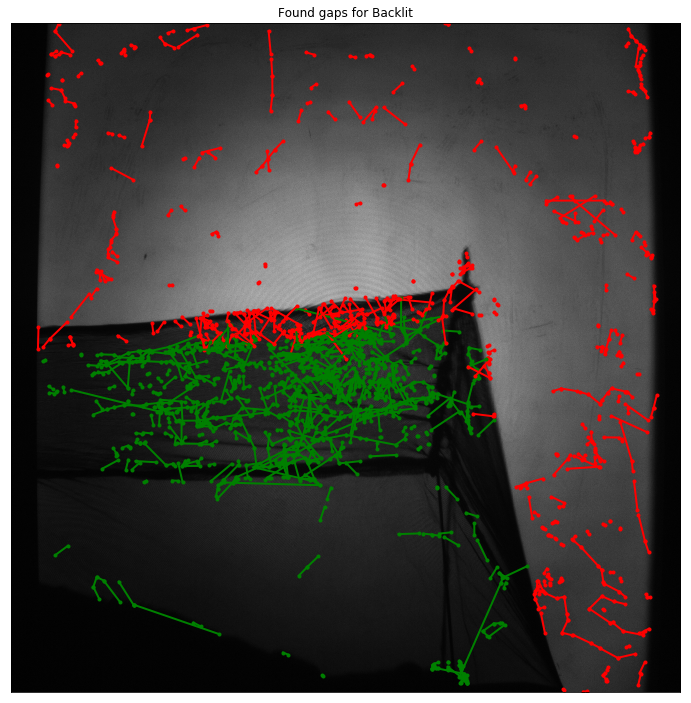

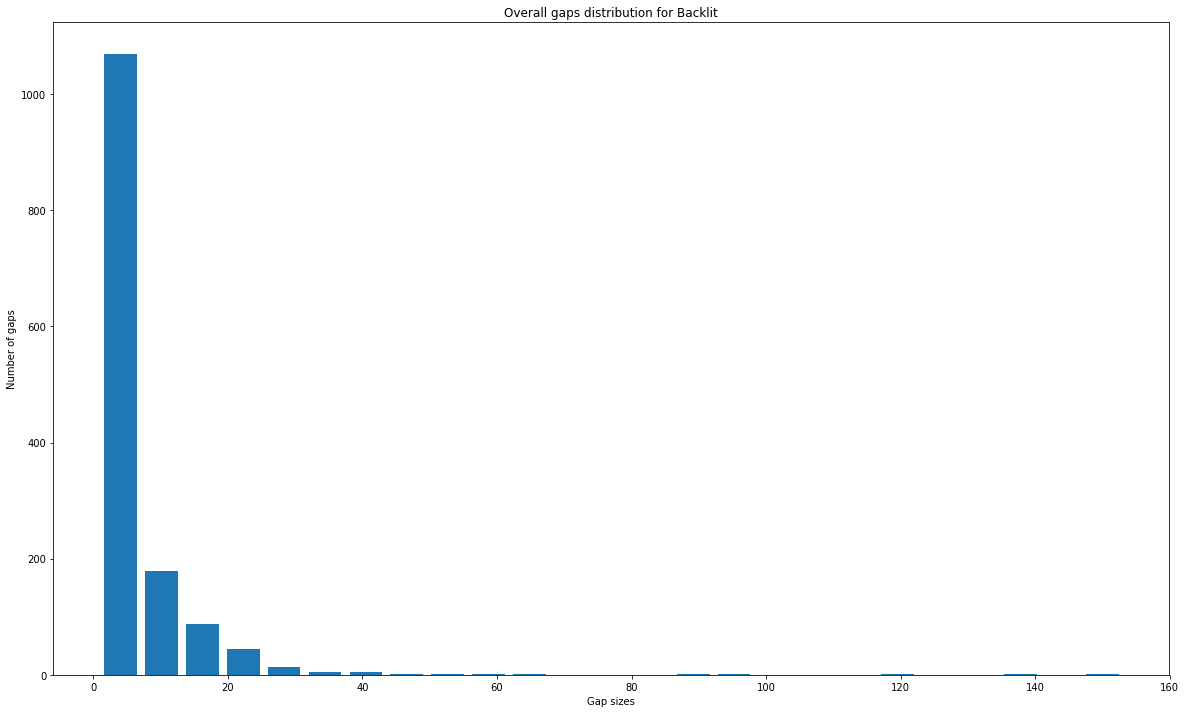

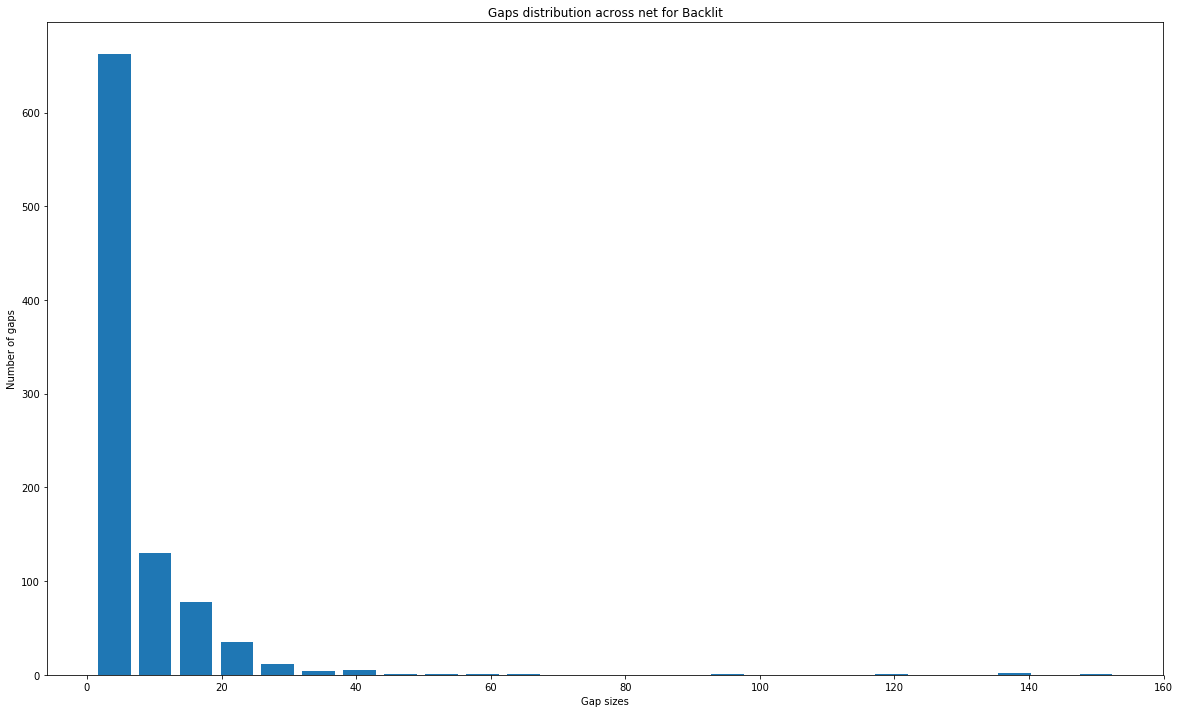

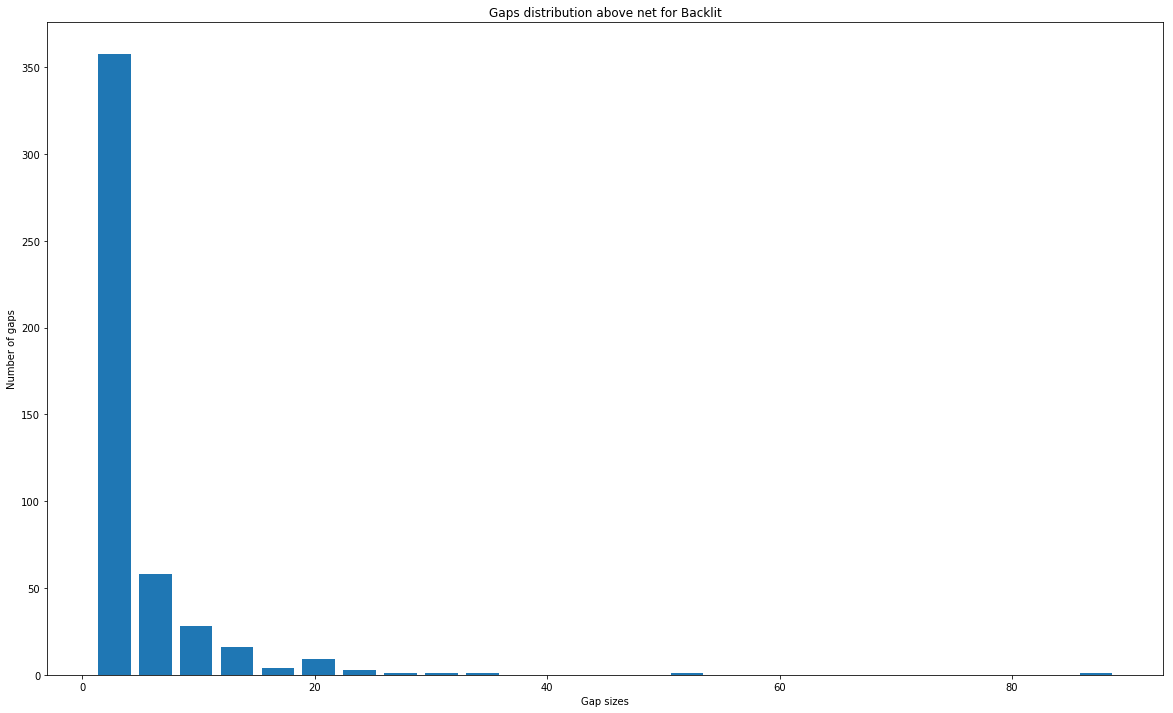

In [6]:
fileBaseDir = './GapsData/BackLit/'

filelist = ['backlit_feet_tracks.txt']

seqFile = 'backlit_1frame_feet.seq'

posFileList = [['backlit_feet_pos_combined_C.txt'],]
titles = ['Backlit']

root = Tk()

openedFile=False

netPols = []

if messagebox.askyesno("Load polygons?","Would you like to load polygons from a file?"):
    polFile = filedialog.askopenfile(initialdir = "./",title = "Select polygons file",filetypes = (("Well Known Text","*.wkt"),("All files","*.*")))
    openedFile=True
    f = open(polFile.name,mode='r')
    netPol = wktLoads(f)
    f.close()
else:
    netPol=None

root.quit()

total = []

if netPol is None:
    [netPolygon,bgImage] = detectPolygon(seqFile=fileBaseDir+seqFile,returnImage=True,root=root)
    netPol = netPolygon
else:
    [bgImage] = detectPolygon(seqFile=fileBaseDir+seqFile,returnImage=True,root=root,returnPolygon=False)

for i,(fileName,posFiles,title) in enumerate(zip(filelist,posFileList,titles)):
    res = calcGaps(fileName=fileBaseDir+fileName,netPolygon=netPol,returnGapSets=True,drawGaps=True,drawHist=True,bgImage=bgImage,title=title)
    posNumAll =0
    for posFile in posFiles:
        positions = np.loadtxt(fileBaseDir+posFile)
        posNumAll += positions.shape[0]
    total.append(list(res)+[posNumAll])

if not openedFile:
    if messagebox.askyesno("Save polygons?","Would you like to save polygons to a file?"):
        polNewFile = filedialog.asksaveasfile(initialdir = "./",title = "Select polygons file",filetypes = (("Well Known Text","*.wkt"),("All files","*.*")))
        f = open(polNewFile.name,mode='w')
#         f.write(wktDumps(MultiPolygon(netPols)))
        f.write(wktDumps(netPol))
        f.close()
root.destroy()

In [7]:
for i in range(len(total)):

    totalNumPositions,undetectedNumPositions,numGapsAll,meanGapAll,SDGapAll,\
            netNumPositions,netUndetectedNumPositions,numGapsNet,meanGapNet,SDGapNet,\
            noNetNumPositions,noNetUndetectedNumPositions,numGapsNoNet,meanGapNoNet,SDGapNoNet,\
            posNumTracks,trackAvLen,trackUnAvLen,posNumAll = total[i][:-4]+[total[i][-1]]

    print('-------------------\n')
    print(f'For {titles[i]} total number of possible positions is {totalNumPositions}, undetected {undetectedNumPositions}, percentrage is '+
          f'{int((1-undetectedNumPositions/totalNumPositions)*100):2},\n{numGapsAll} gaps were found with average size of {meanGapAll:.2f} $\pm$ {SDGapAll:.2f},\n'+
          f'average track length is {trackAvLen:0.2f}, average uninterrupted track length is {trackUnAvLen:0.2f}.\n')
    print(f'For {titles[i]} number of possible positions inside the net is {netNumPositions}, undetected {netUndetectedNumPositions}, percentrage is '+
          f'{int((1-netUndetectedNumPositions/netNumPositions)*100):2},\n{numGapsNet} gaps were found with average size of {meanGapNet:.2f} $\pm$ {SDGapNet:.2f}.\n')
    print(f'For {titles[i]} number of positions outside the net is {noNetNumPositions}, undetected {noNetUndetectedNumPositions}, percentrage is '+
          f'{int((1-noNetUndetectedNumPositions/noNetNumPositions)*100):2},\n{numGapsNoNet} gaps were found with average size of {meanGapNoNet:.2f} $\pm$ {SDGapNoNet:.2f}.\n')
    print(f'Number of tracked positions (vs total number of positions) is {posNumTracks:0}/{posNumAll:0}.\n') 

    print(f'{titles[i]} & {posNumTracks:.0f}/ {posNumAll:.0f} & {totalNumPositions:.0f} & {netNumPositions:.0f} & {noNetNumPositions:.0f} & {meanGapNet:.2f} $\pm$ {SDGapNet:.2f} & {numGapsNet:.0f} & ' +
         f'{meanGapNoNet:.2f} $\pm$ {SDGapNoNet:.2f} & {numGapsNoNet:.0f} & {meanGapAll:.2f} $\pm$ {SDGapAll:.2f} & {numGapsAll:.0f} & {trackAvLen:0.2f} & {trackUnAvLen:0.2f} &'+
         f'${int((1-netUndetectedNumPositions/netNumPositions)*100):2}\%$ & ${int((1-noNetUndetectedNumPositions/noNetNumPositions)*100):2}\%$ & ${int((1-undetectedNumPositions/totalNumPositions)*100):2}\%$')

    print('-------------------')

-------------------

For Backlit total number of possible positions is 27310.0, undetected 8449.0, percentrage is 69,
1417 gaps were found with average size of 5.96 $\pm$ 10.49,
average track length is 78.02, average uninterrupted track length is 16.82.

For Backlit number of possible positions inside the net is 14127.0, undetected 6440.0, percentrage is 54,
936 gaps were found with average size of 6.88 $\pm$ 11.91.

For Backlit number of positions outside the net is 13532.0, undetected 2009.0, percentrage is 85,
481 gaps were found with average size of 4.18 $\pm$ 6.58.

Number of tracked positions (vs total number of positions) is 19128/28409.

Backlit & 19128/ 28409 & 27310 & 14127 & 13532 & 6.88 $\pm$ 11.91 & 936 & 4.18 $\pm$ 6.58 & 481 & 5.96 $\pm$ 10.49 & 1417 & 78.02 & 16.82 &$54\%$ & $85\%$ & $69\%$
-------------------


### Analysis of RRS system recording

./GapsData/RRS/RRS_Cam02_header.seq


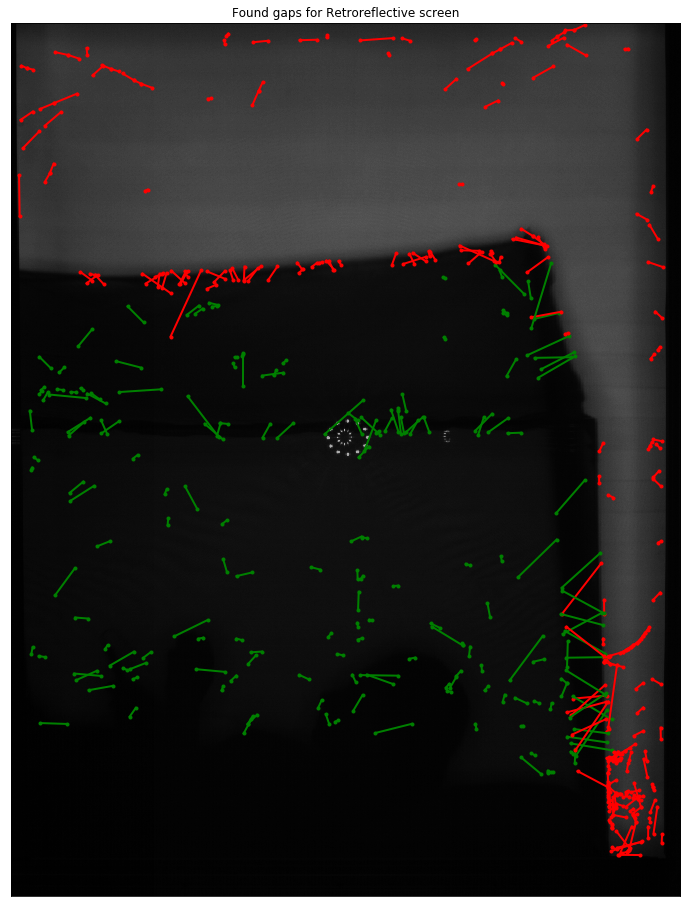

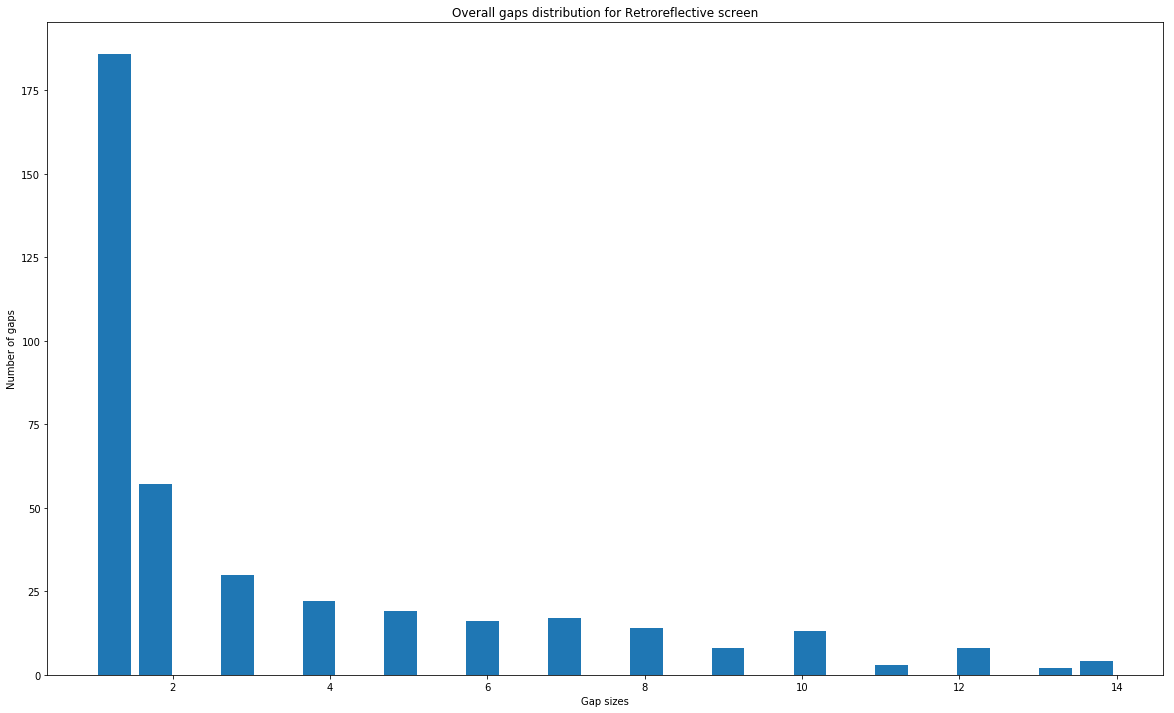

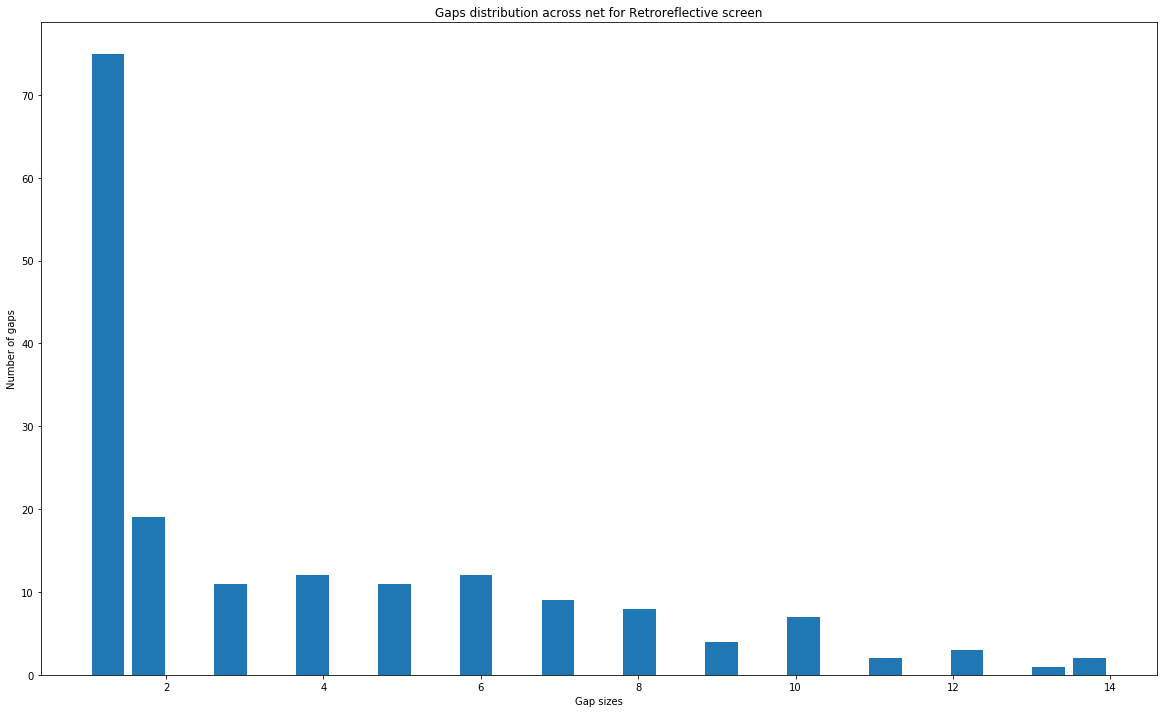

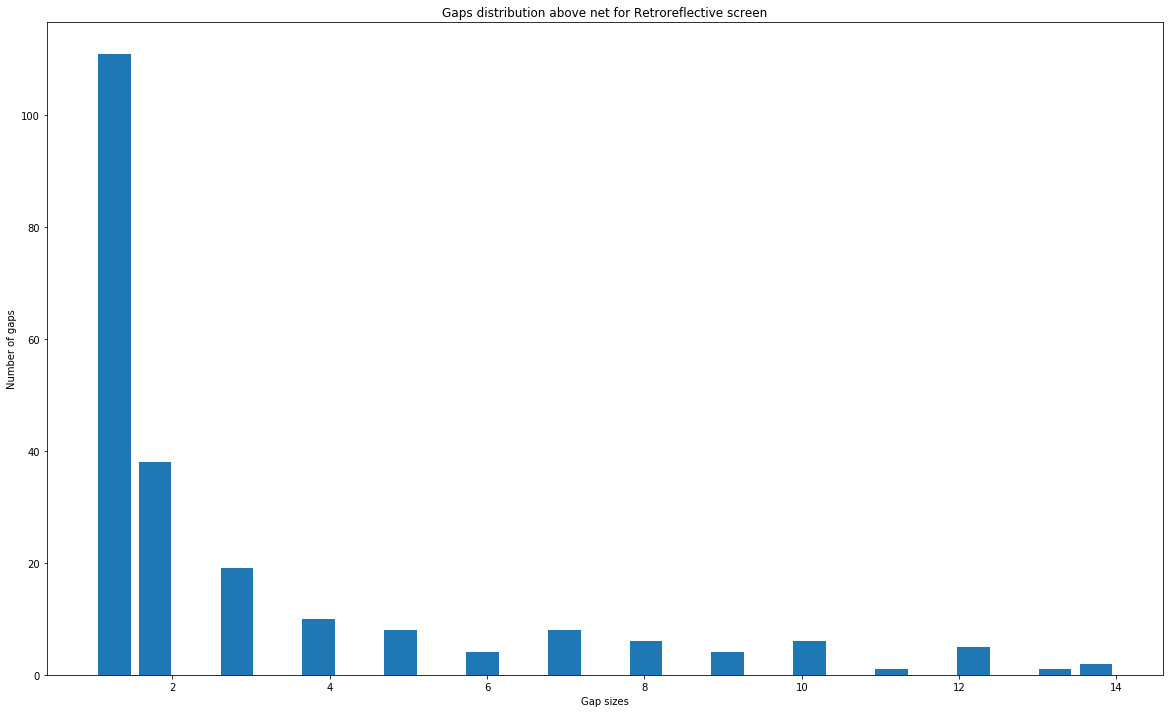

In [8]:
fileBaseDir = './GapsData/RRS/'

filelist = ['RRS_Cam02_trk_new2.txt']

seqFile = 'RRS_Cam02_header.seq'

posFileList = [['RRS_Cam02_pos_all_clean.txt'],]
titles = ['Retroreflective screen']

root = Tk()

openedFile=False

netPols = []

if messagebox.askyesno("Load polygons?","Would you like to load polygons from a file?"):
    polFile = filedialog.askopenfile(initialdir = "./",title = "Select polygons file",filetypes = (("Well Known Text","*.wkt"),("All files","*.*")))
    openedFile=True
    f = open(polFile.name,mode='r')
#     netPols = wktLoads(f)
    netPol = wktLoads(f)
    f.close()
else:
    netPol=None

root.quit()

total = []

if netPol is None:
    [netPolygon,bgImage] = detectPolygon(seqFile=fileBaseDir+seqFile,returnImage=True,root=root)
    netPol = netPolygon
else:
    [bgImage] = detectPolygon(seqFile=fileBaseDir+seqFile,returnImage=True,root=root,returnPolygon=False)

for i,(fileName,posFiles,title) in enumerate(zip(filelist,posFileList,titles)):
    res = calcGaps(fileName=fileBaseDir+fileName,netPolygon=netPol,returnGapSets=True,drawGaps=True,drawHist=True,bgImage=bgImage,title=title)
    posNumAll =0
    for posFile in posFiles:
        positions = np.loadtxt(fileBaseDir+posFile)
        posNumAll += positions.shape[0]
    total.append(list(res)+[posNumAll])

if not openedFile:
    if messagebox.askyesno("Save polygons?","Would you like to save polygons to a file?"):
        polNewFile = filedialog.asksaveasfile(initialdir = "./",title = "Select polygons file",filetypes = (("Well Known Text","*.wkt"),("All files","*.*")))
        f = open(polNewFile.name,mode='w')
        f.write(wktDumps(netPol))
        f.close()
root.destroy()

In [9]:
for i in range(len(total)):

    totalNumPositions,undetectedNumPositions,numGapsAll,meanGapAll,SDGapAll,\
            netNumPositions,netUndetectedNumPositions,numGapsNet,meanGapNet,SDGapNet,\
            noNetNumPositions,noNetUndetectedNumPositions,numGapsNoNet,meanGapNoNet,SDGapNoNet,\
            posNumTracks,trackAvLen,trackUnAvLen,posNumAll = total[i][:-4]+[total[i][-1]]

    print('-------------------\n')
    print(f'For {titles[i]} total number of possible positions is {totalNumPositions}, undetected {undetectedNumPositions}, percentrage is '+
          f'{int((1-undetectedNumPositions/totalNumPositions)*100):2},\n{numGapsAll} gaps were found with average size of {meanGapAll:.2f} $\pm$ {SDGapAll:.2f},\n'+
          f'average track length is {trackAvLen:0.2f}, average uninterrupted track length is {trackUnAvLen:0.2f}.\n')
    print(f'For {titles[i]} number of possible positions inside the net is {netNumPositions}, undetected {netUndetectedNumPositions}, percentrage is '+
          f'{int((1-netUndetectedNumPositions/netNumPositions)*100):2},\n{numGapsNet} gaps were found with average size of {meanGapNet:.2f} $\pm$ {SDGapNet:.2f}.\n')
    print(f'For {titles[i]} number of positions outside the net is {noNetNumPositions}, undetected {noNetUndetectedNumPositions}, percentrage is '+
          f'{int((1-noNetUndetectedNumPositions/noNetNumPositions)*100):2},\n{numGapsNoNet} gaps were found with average size of {meanGapNoNet:.2f} $\pm$ {SDGapNoNet:.2f}.\n')
    print(f'Number of tracked positions (vs total number of positions) is {posNumTracks:0}/{posNumAll:0}.\n') 

    print(f'{titles[i]} & {posNumTracks:.0f}/ {posNumAll:.0f} & {totalNumPositions:.0f} & {netNumPositions:.0f} & {noNetNumPositions:.0f} & {meanGapNet:.2f} $\pm$ {SDGapNet:.2f} & {numGapsNet:.0f} & ' +
         f'{meanGapNoNet:.2f} $\pm$ {SDGapNoNet:.2f} & {numGapsNoNet:.0f} & {meanGapAll:.2f} $\pm$ {SDGapAll:.2f} & {numGapsAll:.0f} & {trackAvLen:0.2f} & {trackUnAvLen:0.2f} &'+
         f'${int((1-netUndetectedNumPositions/netNumPositions)*100):2}\%$ & ${int((1-noNetUndetectedNumPositions/noNetNumPositions)*100):2}\%$ & ${int((1-undetectedNumPositions/totalNumPositions)*100):2}\%$')

    print('-------------------')

-------------------

For Retroreflective screen total number of possible positions is 23782.0, undetected 1313.0, percentrage is 94,
399 gaps were found with average size of 3.29 $\pm$ 3.20,
average track length is 64.54, average uninterrupted track length is 31.66.

For Retroreflective screen number of possible positions inside the net is 13339.0, undetected 653.0, percentrage is 95,
176 gaps were found with average size of 3.71 $\pm$ 3.32.

For Retroreflective screen number of positions outside the net is 10806.0, undetected 660.0, percentrage is 93,
223 gaps were found with average size of 2.96 $\pm$ 3.06.

Number of tracked positions (vs total number of positions) is 22479/23008.

Retroreflective screen & 22479/ 23008 & 23782 & 13339 & 10806 & 3.71 $\pm$ 3.32 & 176 & 2.96 $\pm$ 3.06 & 223 & 3.29 $\pm$ 3.20 & 399 & 64.54 & 31.66 &$95\%$ & $93\%$ & $94\%$
-------------------
